/tmp/ipykernel_8548/3820061250.py:170: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator, 'gen_GRU_model_%d.h5' % epoch)


epoch 15 d_loss 8.925093 g_loss -0.05686606
epoch 30 d_loss 7.934677 g_loss -0.11426674
epoch 45 d_loss 6.4515495 g_loss -0.2041896
epoch 60 d_loss 4.468919 g_loss -0.34359685
epoch 75 d_loss 2.0949962 g_loss -0.5520629
epoch 90 d_loss 0.3287596 g_loss -0.8145494


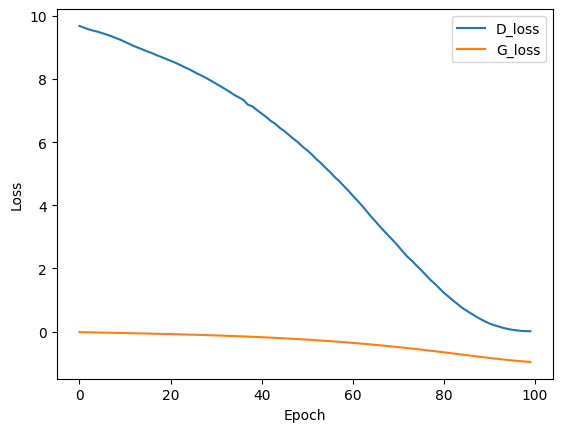

REAL (1746, 1)
[[-0.9801787 ]
 [-0.9812794 ]
 [-0.98266388]
 ...
 [-0.33843275]
 [-0.33313558]
 [-0.3303064 ]]
PREDICTED (1746, 1)
[[-1.0996498 ]
 [-1.0986224 ]
 [-1.1031829 ]
 ...
 [-0.34443724]
 [-0.3473765 ]
 [-0.34943005]]


<Figure size 640x480 with 0 Axes>

In [5]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import GRU, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib

# Load data
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

# Define the generator
def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(input_dim, feature_size),
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(GRU(units=128,
                  #return_sequences=True,
                  recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(128,
    #              kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(8, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    return model

# Define the discriminator
def Discriminator() -> tf.keras.models.Model:
    model = tf.keras.Sequential()
    model.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=True))
    model.add(ReLU())
    model.add(Dense(1))
    return model

# Train WGAN-GP model
class GAN():
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = 128
        checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer,
                                              discriminator_optimizer=self.d_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def gradient_penalty(self, batch_size, real_output, fake_output):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interpolated data
        alpha = tf.random.normal([batch_size, 4, 1], 0.0, 1.0)
        diff = fake_output - tf.cast(real_output, tf.float32)
        interpolated = tf.cast(real_output, tf.float32) + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]

        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_input, real_price, yc = data
        batch_size = tf.shape(real_input)[0]
        for _ in range(1):
            with tf.GradientTape() as d_tape:
                # Train the discriminator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                # Get the logits for the fake images
                D_real = self.discriminator(real_output, training=True)
                # Get the logits for real images
                D_fake = self.discriminator(fake_output, training=True)
                # Calculate discriminator loss using fake and real logits
                real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                d_cost = fake_loss-real_loss
                # Calculate the gradientjiu penalty
                gp = self.gradient_penalty(batch_size, real_output, fake_output)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * 10

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        for _ in range(3):
            with tf.GradientTape() as g_tape:
                # Train the generator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                # Get the discriminator logits for fake images
                G_fake = self.discriminator(fake_output, training=True)
                # Calculate the generator loss
                g_loss = -tf.reduce_mean(G_fake)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, X_train, y_train, yc, epochs):
        data = X_train, y_train, yc
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []


        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(data)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price)
            Real_price.append(real_price)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                tf.keras.models.save_model(generator, 'gen_GRU_model_%d.h5' % epoch)
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)
            
        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig('train_loss.png')

        print("REAL", Real_price.shape)
        print(Real_price)
        print("PREDICTED", Predicted_price.shape)
        print(Predicted_price)

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]
    epoch = 100

    generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = Discriminator()
    gan = GAN(generator, discriminator)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)


----- predicted price ----- [[-1.0996498 ]
 [-1.0986224 ]
 [-1.1031829 ]
 ...
 [-0.34443724]
 [-0.3473765 ]
 [-0.34943005]]
----- rescaled predicted price ----- [[ 4.4302955]
 [ 4.472963 ]
 [ 4.2835584]
 ...
 [35.79562  ]
 [35.673546 ]
 [35.58826  ]]
----- SHAPE rescaled predicted price ----- (1746, 1)


/tmp/ipykernel_8548/1581854979.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  predict_result['predicted_mean'] = predict_result.mean(axis=1)
/tmp/ipykernel_8548/1581854979.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_price['real_mean'] = real_price.mean(axis=1)


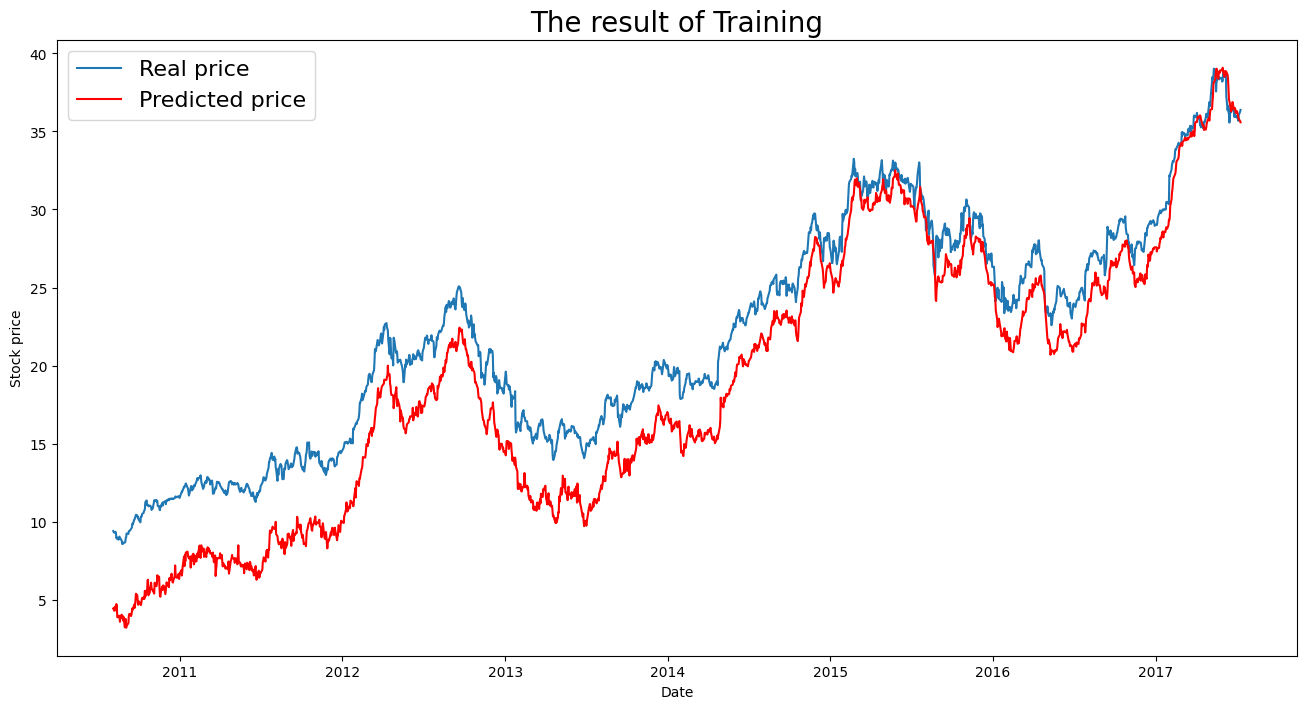

-- Train RMSE --  3.353210693261612


/tmp/ipykernel_8548/1581854979.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_predict_result['predicted_mean'] = test_predict_result.mean(axis=1)
/tmp/ipykernel_8548/1581854979.py:63: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_real_price['real_mean'] = test_real_price.mean(axis=1)


<Figure size 640x480 with 0 Axes>

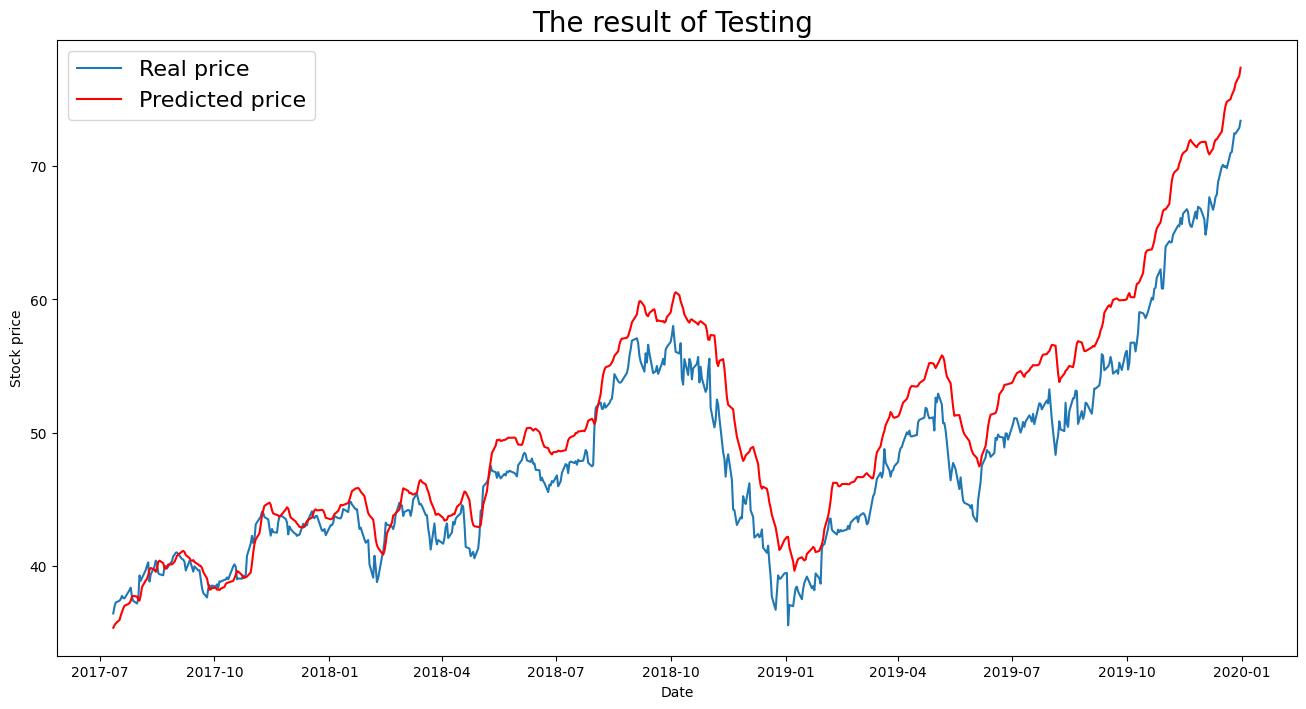

-- Test RMSE --  3.1376259232994386


<Figure size 640x480 with 0 Axes>

In [6]:
# Rescale back the real dataset
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
train_predict_index = np.load("index_train.npy", allow_pickle=True)
test_predict_index = np.load("index_test.npy", allow_pickle=True)

print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result for training data
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color='r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()
plt.savefig('train_plot.png')

# Calculate RMSE for training data
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis=1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- Train RMSE -- ', RMSE)

# Test the model on test data
y_test_predicted = generator(X_test)
rescaled_y_test = y_scaler.inverse_transform(y_test)
rescaled_y_test_predicted = y_scaler.inverse_transform(y_test_predicted)

# Create DataFrame for test predictions
test_predict_result = pd.DataFrame()
for i in range(rescaled_y_test_predicted.shape[0]):
    y_predict = pd.DataFrame(rescaled_y_test_predicted[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
    test_predict_result = pd.concat([test_predict_result, y_predict], axis=1, sort=False)

test_real_price = pd.DataFrame()
for i in range(rescaled_y_test.shape[0]):
    y_test_real = pd.DataFrame(rescaled_y_test[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
    test_real_price = pd.concat([test_real_price, y_test_real], axis=1, sort=False)

test_predict_result['predicted_mean'] = test_predict_result.mean(axis=1)
test_real_price['real_mean'] = test_real_price.mean(axis=1)

# Filter data to include only dates before 2020-01
cut_off_date = '2020-01-01'
test_predict_result = test_predict_result.loc[test_predict_result.index < cut_off_date]
test_real_price = test_real_price.loc[test_real_price.index < cut_off_date]

# Plot the test result
plt.figure(figsize=(16, 8))
plt.plot(test_real_price["real_mean"], label="Real price")
plt.plot(test_predict_result["predicted_mean"], color='r', label="Predicted price")
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(loc="upper left", fontsize=16)
plt.title("The result of Testing ", fontsize=20)
plt.show()
plt.savefig('test_plot.png')

# Calculate RMSE for test data
test_RMSE = np.sqrt(mean_squared_error(test_real_price["real_mean"], test_predict_result["predicted_mean"]))
print('-- Test RMSE -- ', test_RMSE)
